<a href="https://colab.research.google.com/github/nataliachmurak/colourisation/blob/main/landscape_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
import os
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import tensorflow as tf


#importing cifar 
from matplotlib import pyplot
from keras.datasets import cifar10
from keras import backend as K


#importing keras
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.metrics import AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from keras.callbacks import Callback

#parameters searches
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import save_model, load_model

#colour schemes
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.color import rgb2gray
from skimage.io import imsave, imread
from skimage import io
from skimage.transform import resize

from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import numpy as np 

#others
import numpy as np
import os
import random
import tensorflow as tf
import cv2
import math

In [ ]:
import os
input_dir = "drive/MyDrive/kaggle_dataset"



# Get images from the input directory. I have put the jpg images in here, but change the extension if the images are in a different format:

# This will just loop through all the images in the directory and keep all paths that end in jpg (or whatever other extension you set):

image_paths = [os.path.join(input_dir, file_name) for file_name in os.listdir(input_dir) if file_name.endswith(".jpg")]

In [ ]:
split = 0.8

# Setting the index:
ix = int(split * len(image_paths))

train_paths, test_paths = image_paths[:ix], image_paths[ix:]

In [ ]:
from tensorflow import keras

import numpy as np

from tensorflow.keras.preprocessing.image import load_img


# Class to help us iterate over the data - I have called it OurDataset, but give it a better name ;-)
class LandscapeDataset(keras.utils.Sequence):
  def __init__(self, batch_size, image_size, img_paths):
    self.batch_size = batch_size
    self.image_size = image_size  
    self.img_paths = img_paths
  def __len__(self):
    return len(self.img_paths) // self.batch_size
# Returns (input, target) tuple from batch index - this would return something like train_x, train_y:
  def __getitem__(self, idx):
# Paths for the batch to return:
    i = idx * self.batch_size
    batch_img_paths = self.img_paths[i : i + self.batch_size]
    # Array to keep all input images (this is just a placeholder at this point) - the input image is set to have one channel (the L channel):
    x = np.zeros((self.batch_size,) + self.image_size + (1,), dtype="float32")
    # Array to keep all label images (this is just a placeholder at this point) - the output label image is set to have two channels (the ab channel):
    y = np.zeros((self.batch_size,) + self.image_size + (2,), dtype="float32")
    for j, path in enumerate(batch_img_paths):
        # Load one image:
       img = load_img(path, target_size=self.image_size)
       input_img = np.array(img) / 255.0
       input_img = rgb2lab(input_img)[:,:,0]
       input_img = np.expand_dims(input_img, 2)
       output_img = img
       output_img = rgb2lab(output_img)[:,:,1:]
       output_img = output_img / 128
       #print(input_img.shape)
       #print(output_img.shape)
  #Y /= 128
       #input_img = np.expand_dims(input_img, 3)
  # Now we place the images in the placeholder arrays we made before:
       x[j] = input_img
       y[j] = output_img
    #print(x.shape)
    #print(x.shape)
    #print(y.shape)
    return x, y


In [ ]:
train_generator = LandscapeDataset(64, (256, 256), train_paths)
#train_generator.__getitem__(1)


test_generator = LandscapeDataset(64, (256, 256), test_paths)

In [ ]:
#building the model 
model = Sequential()
model.add(InputLayer(input_shape=(256, 256, 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

print('Done!')

Done!


In [ ]:
model.compile(optimizer='Adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError(), 'accuracy'])
print('Done!')

Done!


In [ ]:

model.save('my_model.h5')
model = load_model('my_model.h5')

In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [ ]:
epochs = 30
#model.fit(train_generator, epochs=epochs, validation_data=test_generator)
model.fit(train_generator, epochs=epochs, validation_data=test_generator, callbacks=cp_callback)

predictions = model.predict(train_generator)

model.evaluate(train_generator, batch_size=128, verbose=1)

predictions *= 128
print('Done!')
print(predictions.shape)

myit = iter(train_generator)

for i in range(len(train_generator)):
  x, y = next(myit)

print(x.shape)


pyplot.figure(figsize=(30, 30))
for i in range(64):
  cur = np.zeros((256, 256, 3))
  cur[:,:,0] = x[i][:,:,0]
  #test_generator.take()
  #x,y = test_generator.next()
  cur[:,:,1:] = predictions[i]
  final = lab2rgb(cur)
  pyplot.subplot(8, 8, i+1)
  pyplot.imshow(final)
pyplot.show()

Epoch 1/30
52/52 [==============================] - 227s 4s/step - loss: 0.0052 - mean_squared_error: 0.0052 - accuracy: 0.7906 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_accuracy: 0.6611

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/30
52/52 [==============================] - 226s 4s/step - loss: 0.0050 - mean_squared_error: 0.0050 - accuracy: 0.7974 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_accuracy: 0.6937

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/30
52/52 [==============================] - 225s 4s/step - loss: 0.0048 - mean_squared_error: 0.0048 - accuracy: 0.7995 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_accuracy: 0.6932

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/30
52/52 [==============================] - 224s 4s/step - loss: 0.0046 - mean_squared_error: 0.0046 - accuracy: 0.8040 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_accuracy: 0.6711

Epoch 00004: saving model to training_1/

52/52 [==============================] - 195s 4s/step - loss: 0.0149 - mean_squared_error: 0.0149 - accuracy: 0.6382


[0.014881249517202377, 0.014881249517202377, 0.6382182836532593]

In [ ]:
predictions *= 128
print('Done!')
print(predictions.shape)

Done!
(3328, 256, 256, 2)


In [ ]:
myit = iter(train_generator)

for i in range(len(train_generator)):
  x, y = next(myit)

print(x.shape)

(64, 256, 256, 1)


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 52 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 11 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color da

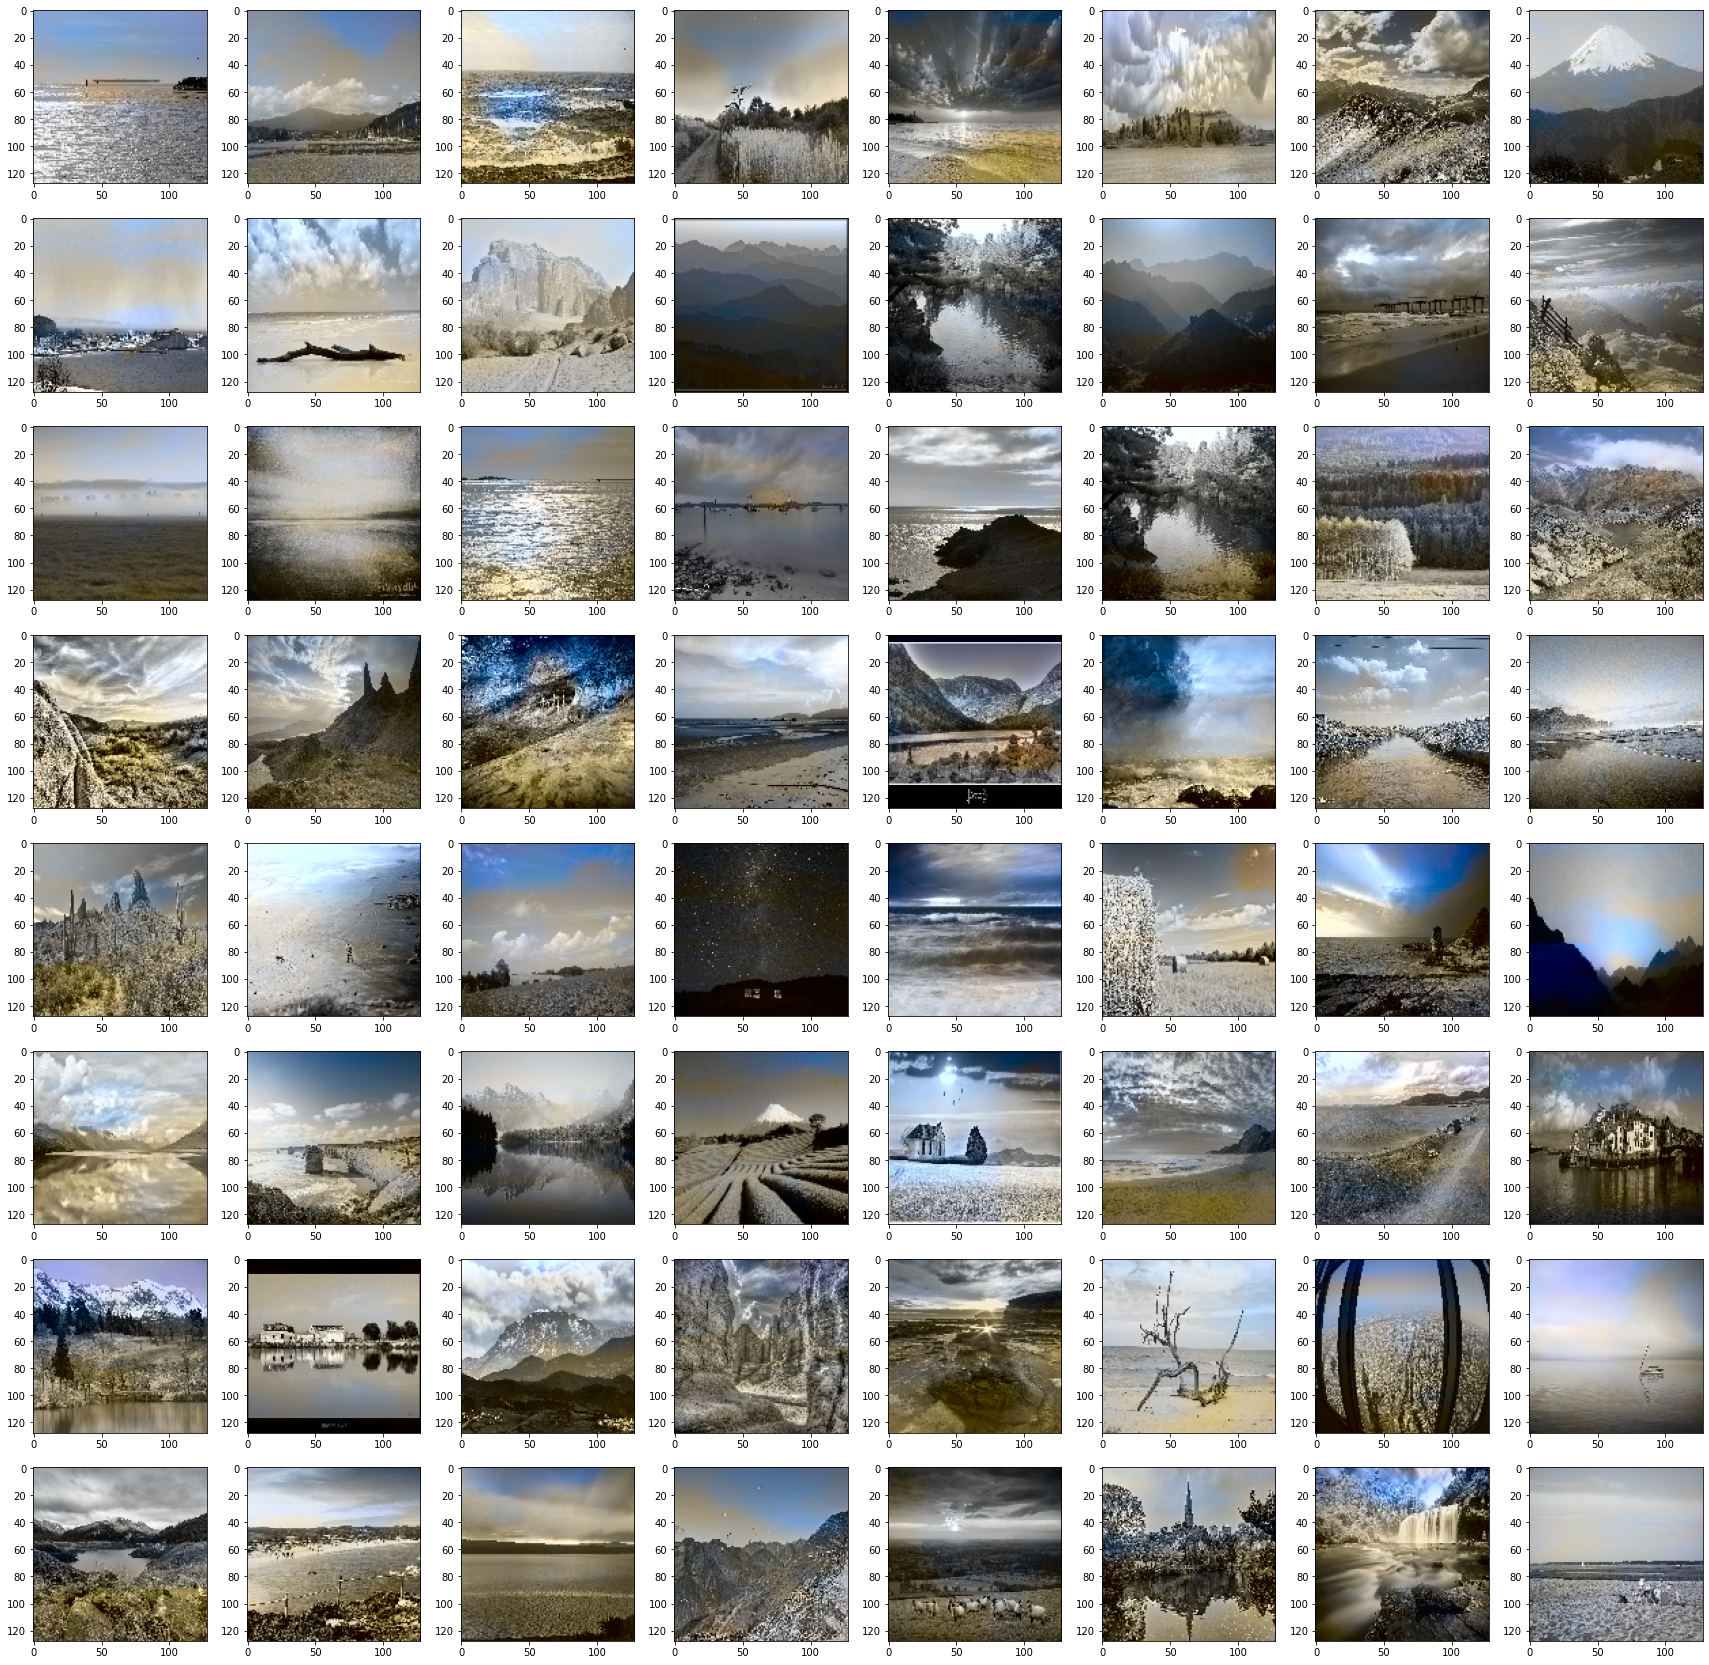

In [ ]:
pyplot.figure(figsize=(30, 30))
for i in range(64):
  cur = np.zeros((128, 128, 3))
  cur[:,:,0] = x[i][:,:,0]
  #test_generator.take()
  #x,y = test_generator.next()
  cur[:,:,1:] = predictions[i]
  final = lab2rgb(cur)
  pyplot.subplot(8, 8, i+1)
  pyplot.imshow(final)
pyplot.show()

In [ ]:
model.evaluate(X, Y, batch_size=128, verbose=1)

output = model.predict(X[:128])
output *= 128
print('Done!')
print(output.shape)

1/1 [==============================] - 23s 23s/step - loss: 0.0170 - mean_squared_error: 0.0170 - accuracy: 0.5915
Done!
(128, 256, 256, 2)


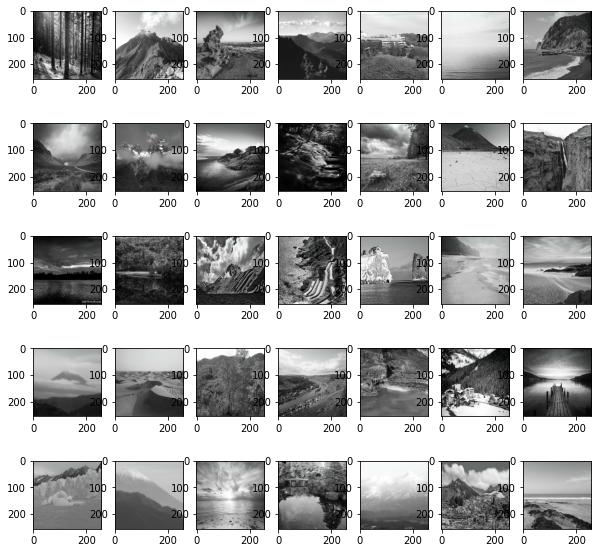

In [ ]:
pyplot.figure(figsize=(10, 10))
for i in range(35):
  cur = np.zeros((256, 256, 3))
  cur[:,:,0] = X[i][:,:,0]
  cur[:,:,1:] = output[i]
  final = lab2rgb(cur)
  pyplot.subplot(5, 7, i+1)
  pyplot.imshow(final)
pyplot.show()